## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [2]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [3]:
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Value ranges of data columns

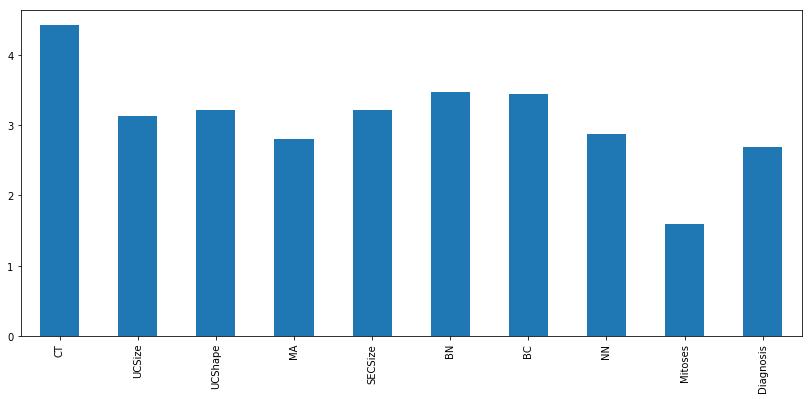

In [4]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

#### Samples from dataset labled as B

In [5]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


#### Samples from dataset labeled as M

In [6]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Bar chart of the total numbers of B and M

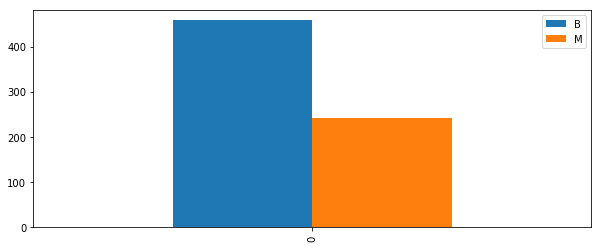

In [7]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Define a data generation function with random noise

In [8]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Expand the set of data samples labeled as M

In [9]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.197469,6.570670,6.560338,5.547349,5.296404,7.563263,5.978252,5.864930,2.585929,4.0
std,2.426906,2.717158,2.558623,3.213075,2.449682,3.178217,2.271544,3.347244,2.557030,0.0
min,1.000000,1.000000,0.909543,0.835700,0.881644,0.000000,1.000000,0.855170,0.623306,4.0
25%,5.000000,4.000000,4.003725,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.027570,6.201923,5.000000,5.000000,9.957277,6.927922,6.000000,1.000000,4.0
75%,10.000000,9.988972,9.000000,8.099654,6.119567,10.000000,7.135085,9.824468,3.000000,4.0
max,10.214204,10.190542,10.186131,10.132010,10.155303,10.171772,10.157903,10.222507,10.185184,4.0


#### Bar chart of the total numbers of B and M after expanding the set of samples labeled as M

,B,M
0,458,482


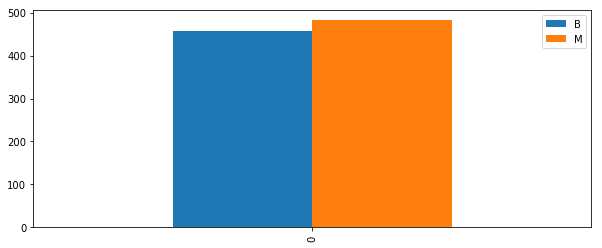

In [10]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))
B_M_df.head()

#### Combine the new set of M samples with the original set of B samples into one new dataset

In [11]:

data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.131043,4.014961,4.067109,3.509385,3.748794,4.514354,4.088848,3.636060,1.844061,3.025532
std,2.979948,3.326277,3.222876,3.185523,2.450840,3.955800,2.640472,3.393914,2.012895,1.000206
min,1.000000,1.000000,0.909543,0.835700,0.881644,0.000000,1.000000,0.855170,0.623306,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,7.000000,7.000000,5.059943,5.000000,9.980254,7.000000,6.000000,1.066868,4.000000
max,10.214204,10.190542,10.186131,10.132010,10.155303,10.171772,10.157903,10.222507,10.185184,4.000000


#### Expand the new combined dataset

In [12]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

('data size = ', 1880)


#### Scale dataset to the range of [0, 1]

In [13]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [14]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

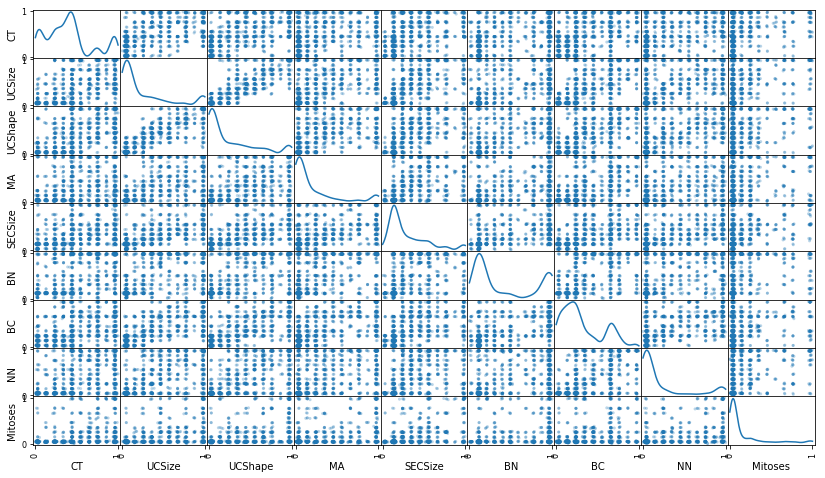

In [15]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

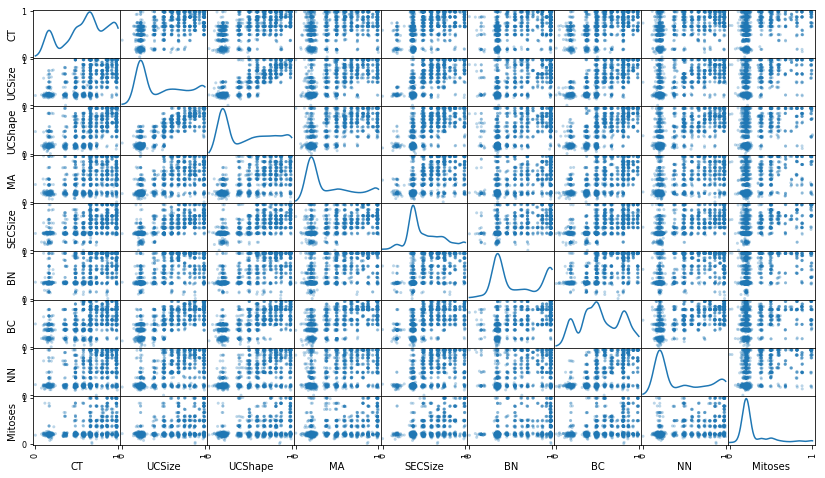

In [16]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [17]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [18]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [19]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.98297872340425529)


#### Deep learning

In [21]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

Using TensorFlow backend.


#### K-fold cross validation

In [25]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X = X_train
Y = y_train

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    model = Sequential()
    model.add(Dense(9, activation='relu', input_dim=9))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu', input_shape=(9,)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', input_shape=(5,)))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    model.fit(X[train], Y[train], epochs=500, batch_size=10, verbose=0)
    
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 97.89%
acc: 95.77%
acc: 99.30%
acc: 97.87%
acc: 96.45%
acc: 97.87%
acc: 96.45%
acc: 98.57%
acc: 98.57%
acc: 97.14%
97.59% (+/- 1.06%)


#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [26]:
#Define your architecture.
model = Sequential()
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_21 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 50        
_________________________________________________________________
dropout_22 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model
* Note that the "accuracy" metrics supports the history of "acc", but the "binary_accuracy" accuracy does not!

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']) # ['binary_accuracy']

#### Train NN Model

In [28]:
# model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=1)

Epoch 1/1000
1410/1410 [==============================] - 0s - loss: 0.7049 - acc: 0.4837     
Epoch 2/1000
1410/1410 [==============================] - 0s - loss: 0.6815 - acc: 0.5021     
Epoch 3/1000
1410/1410 [==============================] - 0s - loss: 0.6818 - acc: 0.5213     
Epoch 4/1000
1410/1410 [==============================] - 0s - loss: 0.6611 - acc: 0.5603     
Epoch 5/1000
1410/1410 [==============================] - 0s - loss: 0.6513 - acc: 0.5596     
Epoch 6/1000
1410/1410 [==============================] - 0s - loss: 0.6272 - acc: 0.6057     
Epoch 7/1000
1410/1410 [==============================] - 0s - loss: 0.6130 - acc: 0.6348     
Epoch 8/1000
1410/1410 [==============================] - 0s - loss: 0.5813 - acc: 0.6553     
Epoch 9/1000
1410/1410 [==============================] - 0s - loss: 0.5722 - acc: 0.6865     
Epoch 10/1000
1410/1410 [==============================] - 0s - loss: 0.5457 - acc: 0.6915     
Epoch 11/1000
1410/1410 [========================

1410/1410 [==============================] - 0s - loss: 0.3424 - acc: 0.8411     
Epoch 87/1000
1410/1410 [==============================] - 0s - loss: 0.3314 - acc: 0.8411     
Epoch 88/1000
1410/1410 [==============================] - 0s - loss: 0.3391 - acc: 0.8340     
Epoch 89/1000
1410/1410 [==============================] - 0s - loss: 0.3234 - acc: 0.8496     
Epoch 90/1000
1410/1410 [==============================] - 0s - loss: 0.3381 - acc: 0.8270     
Epoch 91/1000
1410/1410 [==============================] - 0s - loss: 0.3408 - acc: 0.8319     
Epoch 92/1000
1410/1410 [==============================] - 0s - loss: 0.3438 - acc: 0.8433     
Epoch 93/1000
1410/1410 [==============================] - 0s - loss: 0.3142 - acc: 0.8539     
Epoch 94/1000
1410/1410 [==============================] - 0s - loss: 0.3378 - acc: 0.8482     
Epoch 95/1000
1410/1410 [==============================] - 0s - loss: 0.3258 - acc: 0.8319     
Epoch 96/1000
1410/1410 [=============================

1410/1410 [==============================] - 0s - loss: 0.3287 - acc: 0.8433     
Epoch 171/1000
1410/1410 [==============================] - 0s - loss: 0.3315 - acc: 0.8482     
Epoch 172/1000
1410/1410 [==============================] - 0s - loss: 0.3113 - acc: 0.8539     
Epoch 173/1000
1410/1410 [==============================] - 0s - loss: 0.3061 - acc: 0.8496     
Epoch 174/1000
1410/1410 [==============================] - 0s - loss: 0.3333 - acc: 0.8234     
Epoch 175/1000
1410/1410 [==============================] - 0s - loss: 0.3262 - acc: 0.8404     
Epoch 176/1000
1410/1410 [==============================] - 0s - loss: 0.3268 - acc: 0.8433     
Epoch 177/1000
1410/1410 [==============================] - 0s - loss: 0.3397 - acc: 0.8411     
Epoch 178/1000
1410/1410 [==============================] - 0s - loss: 0.3403 - acc: 0.8312     
Epoch 179/1000
1410/1410 [==============================] - 0s - loss: 0.3365 - acc: 0.8397     
Epoch 180/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3281 - acc: 0.8468     
Epoch 255/1000
1410/1410 [==============================] - 0s - loss: 0.3254 - acc: 0.8397     
Epoch 256/1000
1410/1410 [==============================] - 0s - loss: 0.3260 - acc: 0.8504     
Epoch 257/1000
1410/1410 [==============================] - 0s - loss: 0.3127 - acc: 0.8560     
Epoch 258/1000
1410/1410 [==============================] - 0s - loss: 0.3016 - acc: 0.8645     
Epoch 259/1000
1410/1410 [==============================] - 0s - loss: 0.3001 - acc: 0.8454     
Epoch 260/1000
1410/1410 [==============================] - 0s - loss: 0.2947 - acc: 0.8617     
Epoch 261/1000
1410/1410 [==============================] - 0s - loss: 0.3102 - acc: 0.8582     
Epoch 262/1000
1410/1410 [==============================] - 0s - loss: 0.3169 - acc: 0.8539     
Epoch 263/1000
1410/1410 [==============================] - 0s - loss: 0.3194 - acc: 0.8482     - ETA: 0s - loss: 0.3240 - acc: 0.8
Epoch 264/

1410/1410 [==============================] - 0s - loss: 0.3069 - acc: 0.8596     
Epoch 339/1000
1410/1410 [==============================] - 0s - loss: 0.3370 - acc: 0.8404     
Epoch 340/1000
1410/1410 [==============================] - 0s - loss: 0.3197 - acc: 0.8489     
Epoch 341/1000
1410/1410 [==============================] - 0s - loss: 0.3420 - acc: 0.8454     
Epoch 342/1000
1410/1410 [==============================] - 0s - loss: 0.3257 - acc: 0.8461     
Epoch 343/1000
1410/1410 [==============================] - 0s - loss: 0.3007 - acc: 0.8553     
Epoch 344/1000
1410/1410 [==============================] - 0s - loss: 0.3060 - acc: 0.8574     
Epoch 345/1000
1410/1410 [==============================] - 0s - loss: 0.3249 - acc: 0.8496     
Epoch 346/1000
1410/1410 [==============================] - 0s - loss: 0.3321 - acc: 0.8404     
Epoch 347/1000
1410/1410 [==============================] - 0s - loss: 0.3134 - acc: 0.8496     
Epoch 348/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3163 - acc: 0.8482     
Epoch 423/1000
1410/1410 [==============================] - 0s - loss: 0.3208 - acc: 0.8340     
Epoch 424/1000
1410/1410 [==============================] - 0s - loss: 0.3221 - acc: 0.8440     
Epoch 425/1000
1410/1410 [==============================] - 0s - loss: 0.3059 - acc: 0.8504     
Epoch 426/1000
1410/1410 [==============================] - 0s - loss: 0.3009 - acc: 0.8638     
Epoch 427/1000
1410/1410 [==============================] - 0s - loss: 0.3063 - acc: 0.8525     
Epoch 428/1000
1410/1410 [==============================] - 0s - loss: 0.3103 - acc: 0.8652     
Epoch 429/1000
1410/1410 [==============================] - 0s - loss: 0.3071 - acc: 0.8433     
Epoch 430/1000
1410/1410 [==============================] - 0s - loss: 0.3047 - acc: 0.8532     
Epoch 431/1000
1410/1410 [==============================] - 0s - loss: 0.3083 - acc: 0.8603     
Epoch 432/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3197 - acc: 0.8518     
Epoch 507/1000
1410/1410 [==============================] - 0s - loss: 0.3045 - acc: 0.8433     
Epoch 508/1000
1410/1410 [==============================] - 0s - loss: 0.3329 - acc: 0.8454     
Epoch 509/1000
1410/1410 [==============================] - 0s - loss: 0.3109 - acc: 0.8674     
Epoch 510/1000
1410/1410 [==============================] - 0s - loss: 0.3100 - acc: 0.8440     
Epoch 511/1000
1410/1410 [==============================] - 0s - loss: 0.3208 - acc: 0.8440     
Epoch 512/1000
1410/1410 [==============================] - 0s - loss: 0.3135 - acc: 0.8553     
Epoch 513/1000
1410/1410 [==============================] - 0s - loss: 0.3417 - acc: 0.8355     
Epoch 514/1000
1410/1410 [==============================] - 0s - loss: 0.3334 - acc: 0.8482     
Epoch 515/1000
1410/1410 [==============================] - 0s - loss: 0.3078 - acc: 0.8489     
Epoch 516/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2942 - acc: 0.8617     
Epoch 591/1000
1410/1410 [==============================] - 0s - loss: 0.3264 - acc: 0.8348     
Epoch 592/1000
1410/1410 [==============================] - 0s - loss: 0.3085 - acc: 0.8574     
Epoch 593/1000
1410/1410 [==============================] - 0s - loss: 0.3212 - acc: 0.8454     
Epoch 594/1000
1410/1410 [==============================] - 0s - loss: 0.3295 - acc: 0.8333     
Epoch 595/1000
1410/1410 [==============================] - 0s - loss: 0.3015 - acc: 0.8667     
Epoch 596/1000
1410/1410 [==============================] - 0s - loss: 0.3187 - acc: 0.8539     
Epoch 597/1000
1410/1410 [==============================] - 0s - loss: 0.3234 - acc: 0.8468     
Epoch 598/1000
1410/1410 [==============================] - 0s - loss: 0.3109 - acc: 0.8496     
Epoch 599/1000
1410/1410 [==============================] - 0s - loss: 0.3032 - acc: 0.8518     
Epoch 600/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3030 - acc: 0.8645     
Epoch 675/1000
1410/1410 [==============================] - 0s - loss: 0.3046 - acc: 0.8574     
Epoch 676/1000
1410/1410 [==============================] - 0s - loss: 0.3199 - acc: 0.8383     
Epoch 677/1000
1410/1410 [==============================] - 0s - loss: 0.3053 - acc: 0.8560     
Epoch 678/1000
1410/1410 [==============================] - 0s - loss: 0.3164 - acc: 0.8582     
Epoch 679/1000
1410/1410 [==============================] - 0s - loss: 0.3372 - acc: 0.8348     
Epoch 680/1000
1410/1410 [==============================] - 0s - loss: 0.3022 - acc: 0.8553     
Epoch 681/1000
1410/1410 [==============================] - 0s - loss: 0.3150 - acc: 0.8511     
Epoch 682/1000
1410/1410 [==============================] - 0s - loss: 0.3149 - acc: 0.8496     
Epoch 683/1000
1410/1410 [==============================] - 0s - loss: 0.3137 - acc: 0.8525     
Epoch 684/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3091 - acc: 0.8475     
Epoch 759/1000
1410/1410 [==============================] - 0s - loss: 0.2986 - acc: 0.8617     
Epoch 760/1000
1410/1410 [==============================] - 0s - loss: 0.3005 - acc: 0.8518     
Epoch 761/1000
1410/1410 [==============================] - 0s - loss: 0.3346 - acc: 0.8433     
Epoch 762/1000
1410/1410 [==============================] - 0s - loss: 0.3161 - acc: 0.8511     
Epoch 763/1000
1410/1410 [==============================] - 0s - loss: 0.3280 - acc: 0.8333     
Epoch 764/1000
1410/1410 [==============================] - 0s - loss: 0.3180 - acc: 0.8461     
Epoch 765/1000
1410/1410 [==============================] - 0s - loss: 0.3180 - acc: 0.8440     
Epoch 766/1000
1410/1410 [==============================] - 0s - loss: 0.3291 - acc: 0.8397     
Epoch 767/1000
1410/1410 [==============================] - 0s - loss: 0.3239 - acc: 0.8319     
Epoch 768/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3093 - acc: 0.8468     
Epoch 843/1000
1410/1410 [==============================] - 0s - loss: 0.3083 - acc: 0.8475     
Epoch 844/1000
1410/1410 [==============================] - 0s - loss: 0.3128 - acc: 0.8404     
Epoch 845/1000
1410/1410 [==============================] - 0s - loss: 0.3286 - acc: 0.8454     
Epoch 846/1000
1410/1410 [==============================] - 0s - loss: 0.3309 - acc: 0.8383     
Epoch 847/1000
1410/1410 [==============================] - 0s - loss: 0.3074 - acc: 0.8567     
Epoch 848/1000
1410/1410 [==============================] - 0s - loss: 0.3189 - acc: 0.8369     
Epoch 849/1000
1410/1410 [==============================] - 0s - loss: 0.3243 - acc: 0.8518     
Epoch 850/1000
1410/1410 [==============================] - 0s - loss: 0.3266 - acc: 0.8411     
Epoch 851/1000
1410/1410 [==============================] - 0s - loss: 0.2901 - acc: 0.8589     
Epoch 852/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.3068 - acc: 0.8723     
Epoch 927/1000
1410/1410 [==============================] - 0s - loss: 0.3203 - acc: 0.8532     
Epoch 928/1000
1410/1410 [==============================] - 0s - loss: 0.3032 - acc: 0.8532     
Epoch 929/1000
1410/1410 [==============================] - 0s - loss: 0.3204 - acc: 0.8475     
Epoch 930/1000
1410/1410 [==============================] - 0s - loss: 0.3175 - acc: 0.8482     
Epoch 931/1000
1410/1410 [==============================] - 0s - loss: 0.3225 - acc: 0.8397     
Epoch 932/1000
1410/1410 [==============================] - 0s - loss: 0.2969 - acc: 0.8631     
Epoch 933/1000
1410/1410 [==============================] - 0s - loss: 0.3108 - acc: 0.8582     
Epoch 934/1000
1410/1410 [==============================] - 0s - loss: 0.3136 - acc: 0.8596     
Epoch 935/1000
1410/1410 [==============================] - 0s - loss: 0.3234 - acc: 0.8468     
Epoch 936/1000
1410/1410 [===================

<type 'list'>


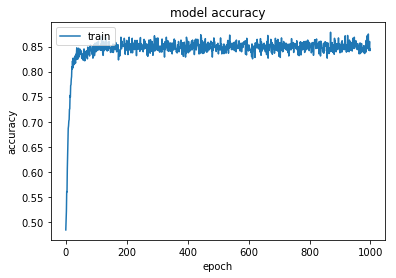

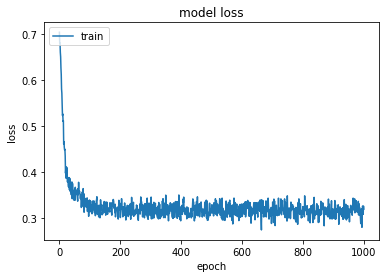

In [29]:
print(type(history.history['acc']))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test NN Model

In [30]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

 16/470 [>.............................] - ETA: 2s('score = ', [0.0843078353462067, 0.97021276595744677])


#### Draw ROC Curve

 32/470 [=>............................] - ETA: 1s

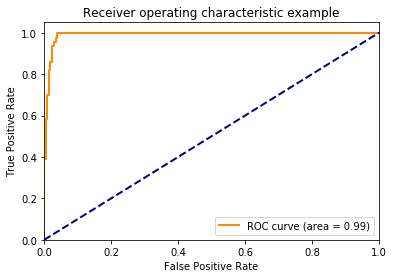

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()